In [1]:
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from pyspark.sql.functions import col


<ipython-input-9-1d4cf4836617>:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


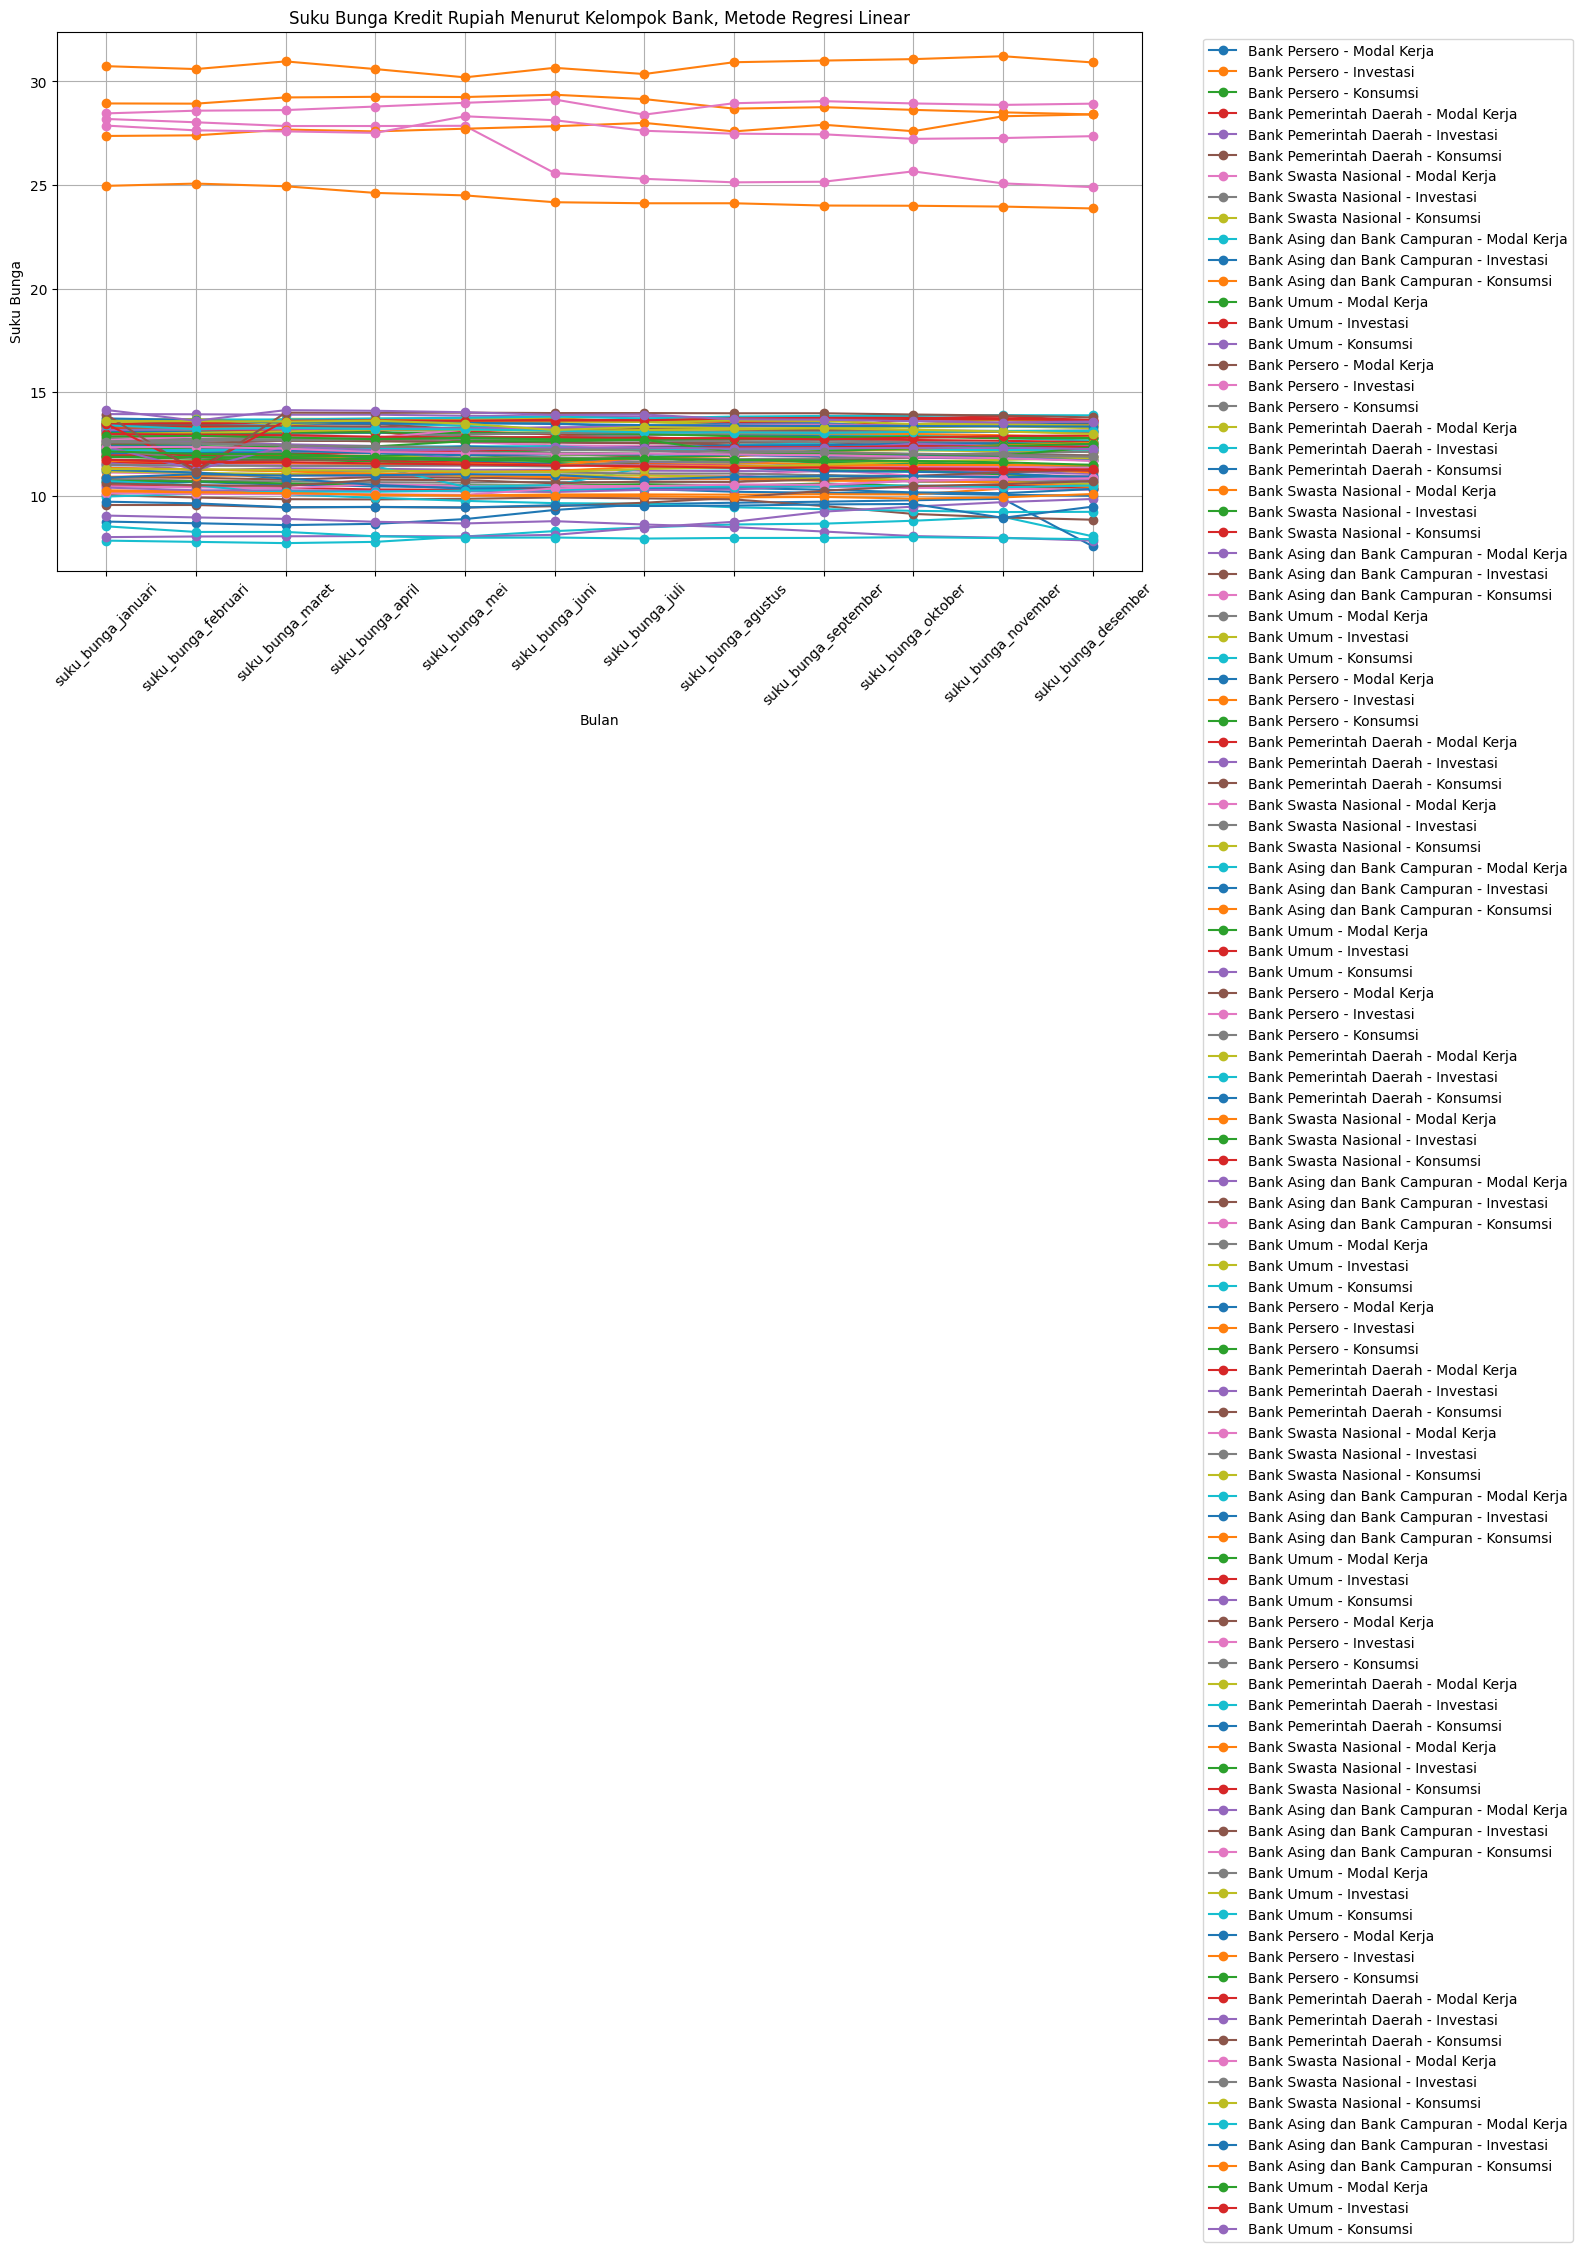

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import udf

spark = SparkSession.builder.appName('Suku Bunga').getOrCreate()

# Assuming the 'SukuBunga.csv' file contains columns like 'Kelompok Bank', 'Tahun', 'Januari', 'Februari', etc.
df = spark.read.csv('SukuBunga.csv', header=True, inferSchema=True)

# Transposisi data
df_transposed = df.select(col("Kelompok Bank"),
                         col("Tahun").alias("suku_bunga_tahun"),
                         col("Januari").alias("suku_bunga_januari"),
                         col("Februari").alias("suku_bunga_februari"),
                         col("Maret").alias("suku_bunga_maret"),
                         col("April").alias("suku_bunga_april"),
                         col("Mei").alias("suku_bunga_mei"),
                         col("Juni").alias("suku_bunga_juni"),
                         col("Juli").alias("suku_bunga_juli"),
                         col("Agustus").alias("suku_bunga_agustus"),
                         col("September").alias("suku_bunga_september"),
                         col("Oktober").alias("suku_bunga_oktober"),
                         col("November").alias("suku_bunga_november"),
                         col("Desember").alias("suku_bunga_desember"))

# Menghapus baris dengan nilai null atau tidak valid
df_cleaned = df_transposed.na.drop()

# Memilih fitur dan label
features_col = ["suku_bunga_tahun", "suku_bunga_januari", "suku_bunga_februari", "suku_bunga_maret", "suku_bunga_april", "suku_bunga_mei", "suku_bunga_juni", "suku_bunga_juli", "suku_bunga_agustus", "suku_bunga_september", "suku_bunga_oktober", "suku_bunga_november","suku_bunga_desember"]
label_col = "Suku Bunga"

# Ambil data yang diperlukan
data_to_plot = df_cleaned.select("Kelompok Bank", "suku_bunga_tahun", "suku_bunga_januari", "suku_bunga_februari", "suku_bunga_maret", "suku_bunga_april", "suku_bunga_mei", "suku_bunga_juni", "suku_bunga_juli", "suku_bunga_agustus", "suku_bunga_september", "suku_bunga_oktober", "suku_bunga_november","suku_bunga_desember").collect()

# Persiapan data untuk plotting
banks = [row[0] for row in data_to_plot]
suku_bunga_tahun = [row[1] for row in data_to_plot]
suku_bunga_januari = [row[2] for row in data_to_plot]
suku_bunga_februari =  [row[3] for row in data_to_plot]
suku_bunga_maret = [row[4] for row in data_to_plot]
suku_bunga_april = [row[5] for row in data_to_plot]
suku_bunga_mei = [row[6] for row in data_to_plot]
suku_bunga_juni = [row[7] for row in data_to_plot]
suku_bunga_juli = [row[8] for row in data_to_plot]
suku_bunga_agustus = [row[9] for row in data_to_plot]
suku_bunga_september = [row[10] for row in data_to_plot]
suku_bunga_oktober = [row[11] for row in data_to_plot]
suku_bunga_november = [row[12] for row in data_to_plot]
suku_bunga_desember = [row[13] for row in data_to_plot]

# Buat visualisasi dengan diagram garis
plt.figure(figsize=(14, 7))

# Plot untuk suku bunga setiap bulan
for i in range(len(suku_bunga_tahun)):
    plt.plot(features_col[1:], [suku_bunga_januari[i], suku_bunga_februari[i], suku_bunga_maret[i], suku_bunga_april[i], suku_bunga_mei[i], suku_bunga_juni[i], suku_bunga_juli[i], suku_bunga_agustus[i], suku_bunga_september[i], suku_bunga_oktober[i], suku_bunga_november[i], suku_bunga_desember[i]], label=banks[i], marker='o')

# Judul dan label sumbu
plt.title('Suku Bunga Kredit Rupiah Menurut Kelompok Bank, Metode Regresi Linear')
plt.xlabel('Bulan')
plt.ylabel('Suku Bunga')
plt.xticks(rotation=45)  # Rotasi label sumbu x untuk menghindari tumpang tindih
plt.grid(True)

# Tampilkan legenda
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Tampilkan plot
plt.tight_layout()
plt.show()


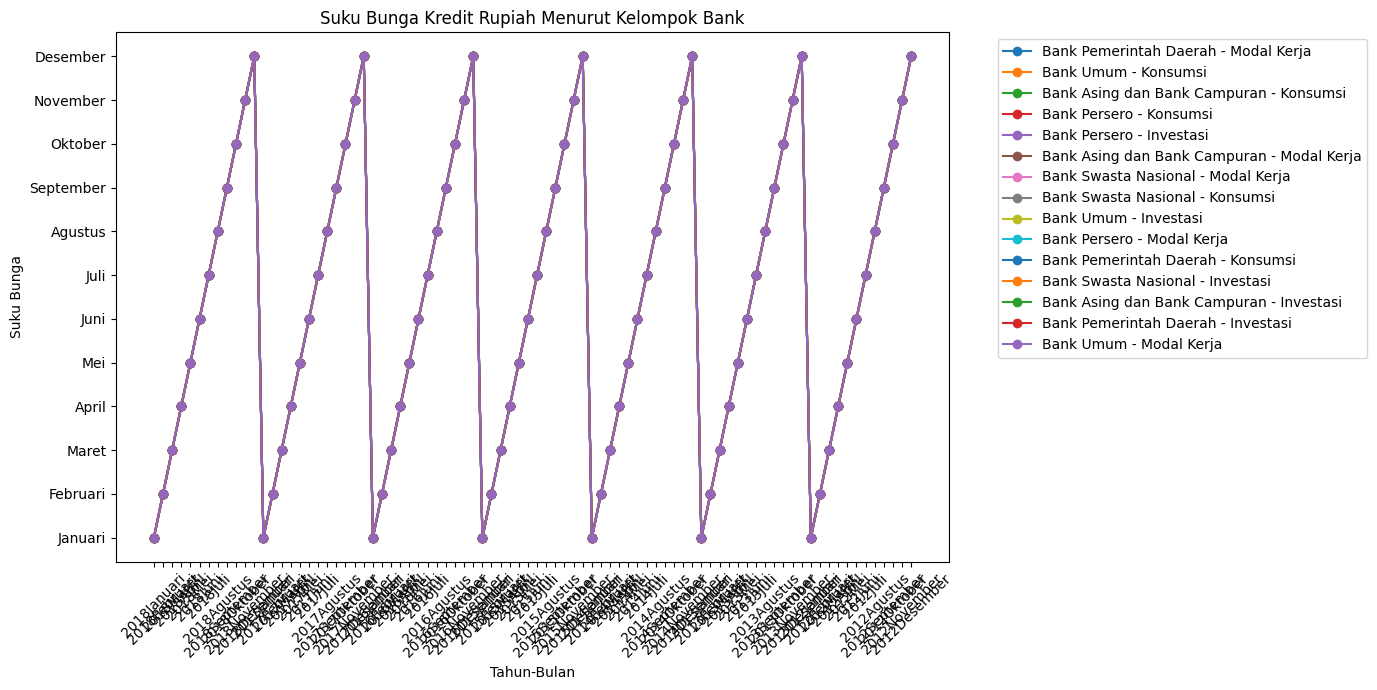

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Create a Spark session
spark = SparkSession.builder.appName('Suku Bunga').getOrCreate()

# Read the data
df = spark.read.csv('SukuBunga.csv', header=True, inferSchema=True)

# Data Preprocessing
# Transpose the data
df_transposed = df.selectExpr("`Kelompok Bank` as Kelompok_Bank", "Tahun",
                               "stack(12, 'Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni', 'Juli', 'Agustus', 'September', 'Oktober', 'November', 'Desember') as (Bulan_Suku_Bunga)")

# Separate the data into training and testing sets
train_data, test_data = df_transposed.randomSplit([0.8, 0.2], seed=42)

# Exploratory Data Analysis (EDA)
# Visualize data, e.g., line plot for each Kelompok Bank over time
plt.figure(figsize=(14, 7))
for bank_group in df_transposed.select("Kelompok_Bank").distinct().collect():
    bank_group = bank_group["Kelompok_Bank"]
    data = df_transposed.filter(df_transposed.Kelompok_Bank == bank_group).toPandas()
    plt.plot(data['Tahun'].astype(str) + data['Bulan_Suku_Bunga'], data['Bulan_Suku_Bunga'].rename('Suku_Bunga'), label=bank_group, marker='o')

plt.title('Suku Bunga Kredit Rupiah Menurut Kelompok Bank')
plt.xlabel('Tahun-Bulan')
plt.ylabel('Suku Bunga')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


